<a href="https://colab.research.google.com/github/sdhomkar/ml_basics/blob/main/ML_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Employing artificial neural networks for denoising noisy decoherence curves:

Siddharth Dhomkar, Department of Physics, IIT Madras

**Based on**:

* D.F. Wise, J.J.L. Morton, and S. Dhomkar, “Using deep learning to understand and mitigate the qubit noise environment”, PRX Quantum 2, 010316 (2021)
https://doi.org/10.1103/PRXQuantum.2.010316

* F. Meneses, D. F. Wise, D. Pagliero, P. R. Zangara, S. Dhomkar, and C. A. Meriles, "Toward Deep-Learning-Assisted Spectrally Resolved Imaging of Magnetic Noise", Physical Review Applied 18, 024004 (2022)
http://dx.doi.org/10.1103/PhysRevApplied.18.024004


Precise extraction of the nature of noise acting on a qubit underpins the optimization of dynamical decoupling protocols that can mitigate such noise. However, extracting accurate noise spectra from typical time-dynamics measurements on qubits is intractable using standard methods. The aforementioned articles propose a methodology to address this challenge using deep learning driven algorithms.

Although, the articles demonstrate a proof-of-principle technique to tackle problems related to precise noise spectroscopy, improved denoising methodology is required to handle incomplete and noisy experimental curves. Moreover, optimal smoothening of noisy data can assist in various applications. Thus, the aim of this notebook is to compare possible **Deep Learning Driven** strategies that can be utilized for this purpose.

### Initilization


#### Import packages

In [14]:
# keras:
# import tensorflow as tf
# from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv1D, LSTM, Input, ReLU
from keras.layers import Flatten, Dropout, Reshape, ZeroPadding1D, Cropping1D
from keras.layers import GlobalAveragePooling1D, AveragePooling1D, UpSampling1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
# from keras import backend as K
from keras.utils import plot_model
from keras import models


# Other useful packages:
import numpy as np
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from tqdm.notebook import trange
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import time

# Import the package to either upload or download files
from google.colab import files

In [2]:
# print(tf.__version__)

2.17.0


#### Figure Template


In [2]:
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 1000,
    'height': 500,
    'font': dict(size=15,color='black'),
    'xaxis': {
        'title': None,
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5,
        'tickwidth': 1.5,
        'ticklen': 5,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
    },
    'yaxis': {
        'title': None,
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5,
        'tickwidth': 1.5,
        'ticklen': 5,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
        }
}

#### Mount Google Drive or Clone Github Repository

In [3]:
!git clone https://github.com/sdhomkar/ml_basics.git

Cloning into 'ml_basics'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 183 (delta 62), reused 0 (delta 0), pack-reused 79 (from 1)
Receiving objects: 100% (183/183), 66.33 MiB | 44.16 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [4]:
!ls "ml_basics/"

CNN		 Dense_history.csv  ML_basics.ipynb	 x_test.npz    y_test.npz
CNN_history.csv  LSTM		    Python_basics.ipynb  x_train1.npz  y_train1.npz
Dense		 LSTM_history.csv   README.md		 x_train2.npz  y_train2.npz


In [5]:
path = "ml_basics"

### Training Data Generation
Usually, generation of appropriate training data requires serious knowledge of the physical system under investigation as well as efficient coding practices. However, for testing purposes, here we are going to generate simple decoherence curves having stretched exponential functional form. Therefore, our training data is going to be fairly primitive and, thus, the predictions are expected to be significantly more accurate than those in case of the "real" experimental curves.

#### Generate Stretched Exponentials

In [22]:
# The function
def simulateCoherence(T2_size,p_size,T0_size):
    T2 = np.linspace(10e-6,100e-6,T2_size)
    p = np.linspace(1.0,3.0,p_size)
    T0 = np.geomspace(0.5e-6,200e-6,T0_size)

    T2_3d, p_3d, T0_3d = np.meshgrid(T2, p, T0)

    C = np.exp(-((T0_3d/T2_3d)**p_3d))
    C = C.reshape(p.size*T2.size,T0.size)
    return C, T0

In [23]:
# Output
n_t2 = 361
n_p = 81
n_time = 151

c_stretch, t = simulateCoherence(n_t2,n_p,n_time)

In [25]:
# Plot
color_str = ["#d9ed92","#b5e48c","#99d98c","#76c893","#52b69a","#34a0a4","#168aad","#1a759f","#1e6091","#184e77"]
n_plot = 7
rand_set = np.random.randint(0,c_stretch.shape[0],(n_plot,))
fig = go.Figure()
for i in range(n_plot):
  fig.add_scatter(x=t*1e6,y=c_stretch[rand_set[i],:],line=dict(width=2,color=color_str[i]),opacity=1,name=f'{rand_set[i]}')
fig.update_layout(template=fig_template,  title = 'Simulated Coherence Curves',
                  width = 800,
                  xaxis = dict(title='Evolution time (\N{greek small letter mu}s)',range=[0,200]),
                  yaxis = dict(title='Coherence'),
                 )

#### Add Random Gaussian Noise

$$ G(x) = \frac{1}{\sqrt[]{2 \pi } \sigma} e^{- \frac{x^{2}}{2 \sigma ^{2}}} $$

In [26]:
# Draw a set of random numbers
sigma = 0.05
exp_noise = np.random.normal(0,sigma,c_stretch.shape)
hist,x =np.histogram(exp_noise[0,:],bins=21,range=[-0.15,0.15],density=False)

x = (x[:-1]+x[1:])/2

fig = go.Figure()
fig.add_trace(go.Bar(x=x,y=hist,opacity=0.75,marker_color='royalblue'))
fig.update_layout(bargap=0)
fig.update_layout(template=fig_template,  title = 'Random Noise',
                  width = 800,
                  xaxis = dict(title='Normalized Noise Amplitude',range=[-0.15,0.15]),
                  yaxis = dict(title='Samples'),
                 )
fig

In [27]:
# Add noise
c_noisy = c_stretch + exp_noise

In [28]:
# Plot
fig = go.Figure()
for i in range(n_plot):
  fig.add_scatter(x=t*1e6,y=c_stretch[rand_set[i],:],line=dict(width=2,color=color_str[i]),opacity=1,name=f'{rand_set[i]}')
  fig.add_scatter(x=t*1e6,y=c_noisy[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Noisy{rand_set[i]}',showlegend=True)
fig.update_layout(template=fig_template,  title = 'Noisy Coherence Curves',
                  width = 800,
                  xaxis = dict(title='Evolution time (\N{greek small letter mu}s)',range=[0,200]),
                  yaxis = dict(title='Coherence'),
                 )

#### Prepare the data for training and testing

In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(c_noisy, c_stretch, test_size=0.15)

Save the generated data to Google Drive and load it whenever necessary

In [ ]:
# Save the in Drive
# np.savez_compressed(path+'/Training_Data',x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

# np.savez_compressed(path+'/x_train1.npz', data=training_data['x_train'][:12000,:])
# np.savez_compressed(path+'/x_train2.npz', data=training_data['x_train'][12000:,:])
# np.savez_compressed(path+'/x_test.npz', data=training_data['x_test'])
# np.savez_compressed(path+'/y_test.npz', data=training_data['y_test'])
# np.savez_compressed(path+'/y_train1.npz', data=training_data['y_train'][:12000,:])
# np.savez_compressed(path+'/y_train2.npz', data=training_data['y_train'][12000:,:])

# Load the data from drive
# training_data = np.load(path+"/Training_Data.npz")

# data = np.load(path+"/x_train1.npz")
# x_train = training_data['x_train']
# x_test = training_data['x_test']
# y_train = training_data['y_train']
# y_test = training_data['y_test']

In [6]:
x_train = np.concatenate((np.load(path+"/x_train1.npz")['data'],np.load(path+"/x_train2.npz")['data']),axis=0)
x_test = np.load(path+"/x_test.npz")['data']
y_train = np.concatenate((np.load(path+"/y_train1.npz")['data'],np.load(path+"/y_train2.npz")['data']),axis=0)
y_test = np.load(path+"/y_test.npz")['data']

In [7]:
x_train.shape, x_test.shape

((24854, 151), (4387, 151))

In [30]:
# Select test datasets at random for plotting
n_plot = 4
rand_set = np.random.randint(0,x_test.shape[0],(n_plot,))

### Training Protocol

1. Set initial learning rate.
2. Monitor loss for validation data.
3. Reduce learning rate if the validation loss plateaus.
4. Automatically save the network with lowest value of validation loss.
5. Stop training if the validation loss does not improve after a given number of epochs.

In [51]:
def training(model, input, output, batch=64, epochs=100):
  ec = EarlyStopping(monitor='val_loss', patience=51),
  mc = ModelCheckpoint(filepath=path+filename+'.keras', monitor='val_loss', save_best_only=True),
  history = model.fit(input,output,batch,epochs,validation_split=0.1,verbose=1,
                  callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7), mc, ec])
  return model, history


#### Evaluating errors in the predictions:
Mean absolute error can be calculated using the predictions and the simulated test data

In [10]:
def percent_error(data_test,data_predict):
  return np.mean(np.abs(data_test-data_predict)*100,axis=1)

In [11]:
n_epochs = 70

### Build, train, and test the networks



*Activation Functions: Rectified Linear Unit (ReLU)*

![Activation Functions](https://miro.medium.com/v2/resize:fit:1356/1*Cfx6Hp6VajcTVN46CSDIHA.png)

Reference: https://medium.com/@shauryagoel/prelu-activation-e294bb21fefa

#### Dense autoencoder

![Dense](https://miro.medium.com/v2/resize:fit:720/1*VHOUViL8dHGfvxCsswPv-Q.png)

Reference: https://medium.com/swlh/fully-connected-vs-convolutional-neural-networks-813ca7bc6ee5


##### Construct the network

In [ ]:
Net=Sequential()
Net.add(Dense(151,activation='relu',input_shape=(151,)))
Net.add(Dense(115,activation='relu'))
Net.add(Dense(115,activation='relu'))
Net.add(Dense(151,activation='linear'))
Net.compile(loss='mean_absolute_error',optimizer=optimizers.Adam(learning_rate=0.001))
Net.summary()

In [ ]:
# trainable_dense = np.sum([K.count_params(w) for w in Net.trainable_weights])
# trainable_dense

71288

##### Train the network


In [ ]:
filename = '/Dense'
start = time.time()
dense, history_dense = training(Net,x_train,y_train,batch=64,epochs=n_epochs)
end = time.time()
time_dense = end - start
print(time_dense)

In [ ]:
# saving the training history
# pd.DataFrame(history_dense.history).to_csv(path+'/Dense_history'+'.csv')

In [18]:
# Loading the trained model
dense = models.load_model(path+'/Dense'+'.keras')

# Loading the training history
history_dense_stored = pd.read_csv(path+'/Dense_history'+'.csv')

##### Test the network

In [19]:
ydense_predict = dense.predict(x_test)
err_dense = percent_error(y_test,ydense_predict)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [20]:
hist_dense,x =np.histogram(err_dense,bins=51,range=[0,2],density=False)
x = (x[:-1]+x[1:])/2

In [59]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Training History - Dense','Mean Absolute Error', 'Comparison'))

fig.add_scatter(x=np.arange(1,n_epochs+1),y=history_dense_stored['val_loss'],line=dict(width=3,color='royalblue'),opacity=1,name=f'Validation loss',row=1,col=1,showlegend=False)
fig.add_trace(go.Bar(x=x,y=hist_dense,opacity=0.75,name='Error',showlegend=False,marker=dict(color='royalblue')),row=1,col=2)
for i in range(n_plot):
  fig.add_scatter(x=t*1e6,y=x_test[rand_set[i],:],line=dict(width=2,color=color_str[i]),opacity=1,name=f'Input-{rand_set[i]}',row=1,col=3)
  fig.add_scatter(x=t*1e6,y=y_test[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Expected-{rand_set[i]}',showlegend=True,row=1,col=3)
  fig.add_scatter(x=t*1e6,y=ydense_predict[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Predicted-{rand_set[i]}',showlegend=True,row=1,col=3)

fig.update_layout(template=fig_template,
                  width = 1000,
                  xaxis1 = dict(title='Epochs'),
                  yaxis1 = dict(title='Mean absolute error on validation set',type="log",),
                  xaxis2 = dict(title='% Error',range=[0,2]),
                  yaxis2 = dict(title='Samples'),
                  xaxis3 = dict(title='Evolution time (\N{greek small letter mu}s)',range=[0,200]),
                  yaxis3 = dict(title='Coherence'),
                 )

#### Long Short-Term Memory (Recurrent Neural Network)

Reference: '*Deep Recurrent Neural Networks for ECG Signal Denoising*' by Karol Antczak
https://arxiv.org/abs/1807.11551

<!-- ![LSTM](https://media.geeksforgeeks.org/wp-content/uploads/newContent1.png) -->
![LSTM](https://miro.medium.com/v2/resize:fit:720/format:webp/1*EgQzN0yoqFZVLMIodlaR7A.png)

<!-- Reference: https://www.geeksforgeeks.org/understanding-of-lstm-networks/ -->
Reference: https://medium.com/@divyanshu132/lstm-and-its-equations-5ee9246d04af

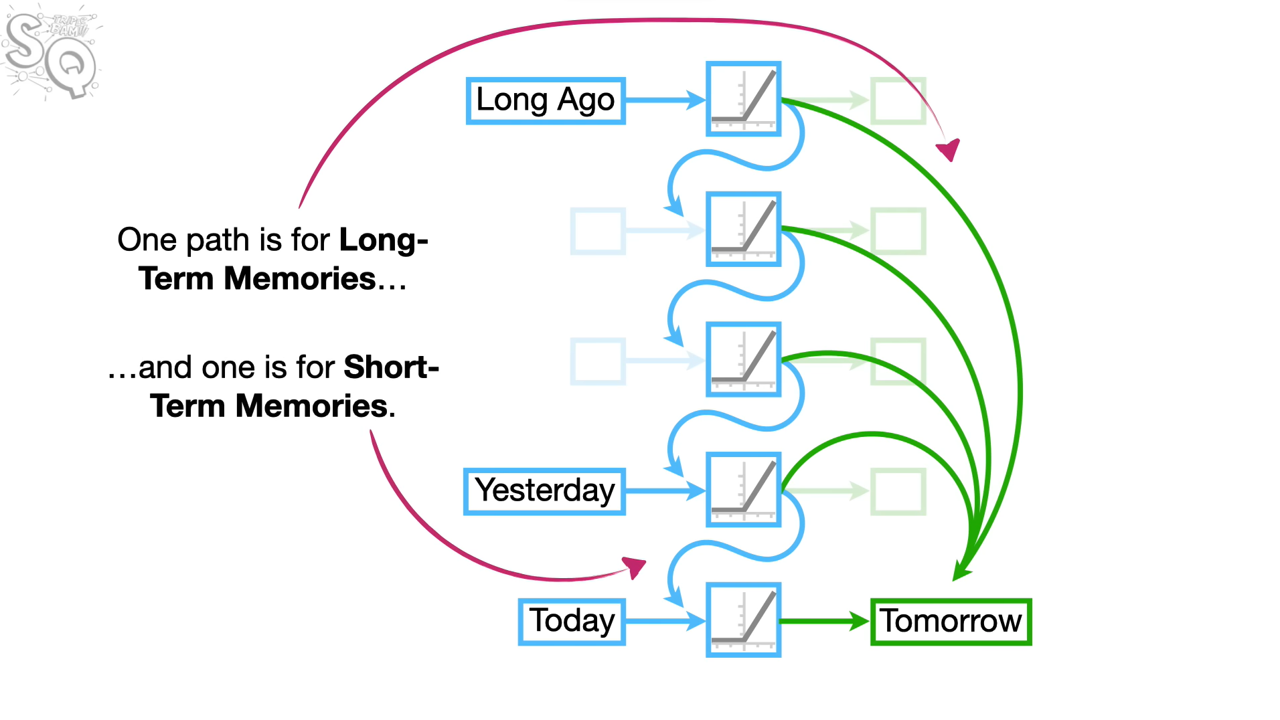

Reference: https://youtu.be/YCzL96nL7j0?si=P7WZMIVP-IaeMX_k

##### Construct the network

In [ ]:
Net=Sequential()
Net.add(LSTM(100,input_shape=(151,1),return_sequences=True))
Net.add(LSTM(40,return_sequences=False))
Net.add(Dense(40,activation="relu"))
Net.add(Dense(151,activation="linear"))
Net.compile(loss='mean_absolute_error',optimizer=optimizers.Adam(learning_rate=0.001))
Net.summary()

In [ ]:
# trainable_lstm = np.sum([K.count_params(w) for w in Net.trainable_weights])
# trainable_lstm

71191

##### Train the network


In [ ]:
filename = '/LSTM'
start = time.time()
lstm, history_lstm = training(Net,x_train,y_train,batch=64,epochs=n_epochs)
end = time.time()
time_lstm = end - start
print(time_lstm)

In [ ]:
# Saving the training history
# pd.DataFrame(history_lstm.history).to_csv(path+'/LSTM_history'+'.csv')

In [39]:
# Loading the trained model
lstm = models.load_model(path+'/LSTM'+'.keras')

# Loading the training history
history_lstm_stored = pd.read_csv(path+'/LSTM_history'+'.csv')

##### Test the network

In [40]:
ylstm_predict = lstm.predict(x_test)
err_lstm = percent_error(y_test,ylstm_predict)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [41]:
hist_lstm,x =np.histogram(err_lstm,bins=51,range=[0,2],density=False)
x = (x[:-1]+x[1:])/2

In [42]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Training History - LSTM','Mean Absolute Error', 'Comparison'))

fig.add_scatter(x=np.arange(1,n_epochs+1),y=history_lstm_stored['val_loss'],line=dict(width=3,color='royalblue'),opacity=1,name=f'Validation loss',row=1,col=1,showlegend=False)
fig.add_trace(go.Bar(x=x,y=hist_lstm,opacity=0.75,name='Error',showlegend=False),row=1,col=2)
for i in range(n_plot):
  fig.add_scatter(x=t*1e6,y=x_test[rand_set[i],:],line=dict(width=2,color=color_str[i]),opacity=1,name=f'Input-{rand_set[i]}',row=1,col=3)
  fig.add_scatter(x=t*1e6,y=y_test[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Expected-{rand_set[i]}',showlegend=True,row=1,col=3)
  fig.add_scatter(x=t*1e6,y=ylstm_predict[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Predicted-{rand_set[i]}',showlegend=True,row=1,col=3)

fig.update_layout(template=fig_template,
                  width = 1000,
                  xaxis1 = dict(title='Epochs'),
                  yaxis1 = dict(title='Mean absolute error on validation set',type="log",),
                  xaxis2 = dict(title='% Error',range=[0,2]),
                  yaxis2 = dict(title='Samples'),
                  xaxis3 = dict(title='Evolution time (\N{greek small letter mu}s)',range=[0,200]),
                  yaxis3 = dict(title='Coherence'),
                 )

#### Convolutional Neural Network

![CNN](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ryCcZ8Omeo3dD1QNmMHoqA.png)

Reference: https://medium.com/swlh/fully-connected-vs-convolutional-neural-networks-813ca7bc6ee5

Note: As the input vector has odd number of elements ZeroPadding layer at input and Cropping layer at output is required to retain the original size of the vector.

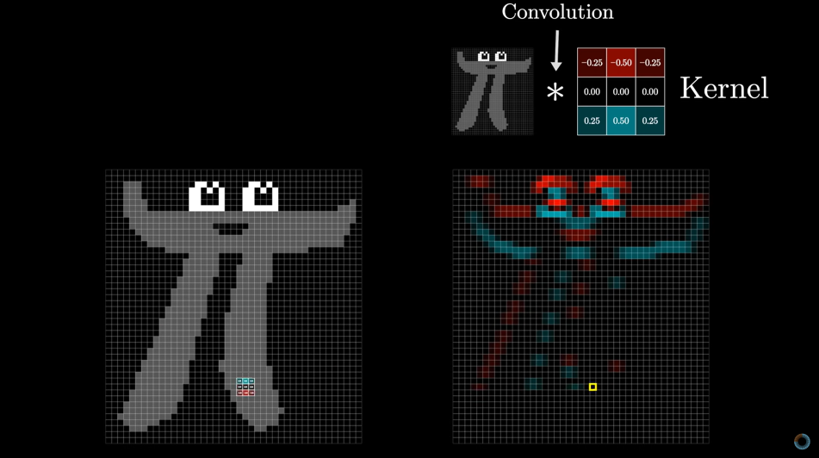

Reference: https://youtu.be/KuXjwB4LzSA?si=FFKtIyjctn3N2Ahu

In [ ]:
Net=Sequential()
Net.add(ZeroPadding1D((0,1),input_shape=(151,1)))
Net.add(Conv1D(filters=96,kernel_size=6,activation="relu",padding='same'))
Net.add(MaxPooling1D(2))
Net.add(Conv1D(filters=48,kernel_size=6,activation="relu",padding='same'))
Net.add(MaxPooling1D(2))
Net.add(Conv1D(filters=24,kernel_size=6,activation="relu",padding='same'))
Net.add(UpSampling1D(2))
Net.add(Conv1D(filters=48,kernel_size=6,activation="relu",padding='same'))
Net.add(UpSampling1D(2))
Net.add(Conv1D(filters=96,kernel_size=6,activation="relu",padding='same'))
Net.add(Dense(1,activation="relu"))
Net.add(Cropping1D((0,1)))
Net.compile(loss='mean_absolute_error',optimizer=optimizers.Adam(learning_rate=0.001))
Net.summary()

In [ ]:
# trainable_cnn = np.sum([K.count_params(w) for w in Net.trainable_weights])
# trainable_cnn

70105

##### Train the network


In [ ]:
filename = '/CNN'
start = time.time()
cnn, history_cnn = training(Net,x_train,y_train,batch=64,epochs=n_epochs)
end = time.time()
time_cnn = end - start
print(time_cnn)

In [ ]:
# Saving the training history
# pd.DataFrame(history_cnn.history).to_csv(path+'/CNN_history'+'.csv')

In [54]:
# Loading the trained model
cnn = models.load_model(path+'/CNN'+'.keras')

# Loading the training history
history_cnn_stored = pd.read_csv(path+'/CNN_history'+'.csv')

##### Test the network

In [55]:
ycnn_predict = np.squeeze(cnn.predict(x_test))
err_cnn = percent_error(y_test,ycnn_predict)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [56]:
hist_cnn,x =np.histogram(err_cnn,bins=51,range=[0,2],density=False)
x = (x[:-1]+x[1:])/2

In [57]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Training History - CNN','Mean Absolute Error', 'Comparison'))

fig.add_scatter(x=np.arange(1,n_epochs+1),y=history_cnn_stored['val_loss'],line=dict(width=3,color='royalblue'),opacity=1,name=f'Validation loss',row=1,col=1,showlegend=False)
fig.add_trace(go.Bar(x=x,y=hist_cnn,opacity=0.75,name='Error',showlegend=False),row=1,col=2)
for i in range(n_plot):
  fig.add_scatter(x=t*1e6,y=x_test[rand_set[i],:],line=dict(width=2,color=color_str[i]),opacity=1,name=f'Input-{rand_set[i]}',row=1,col=3)
  fig.add_scatter(x=t*1e6,y=y_test[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Expected-{rand_set[i]}',showlegend=True,row=1,col=3)
  fig.add_scatter(x=t*1e6,y=ycnn_predict[rand_set[i],:],line=dict(width=3,color=color_str[i]),opacity=0.8,name=f'Predicted-{rand_set[i]}',showlegend=True,row=1,col=3)

fig.update_layout(template=fig_template,
                  width = 1000,
                  xaxis1 = dict(title='Epochs'),
                  yaxis1 = dict(title='Mean absolute error on validation set',type="log",),
                  xaxis2 = dict(title='% Error',range=[0,2]),
                  yaxis2 = dict(title='Samples'),
                  xaxis3 = dict(title='Evolution time (\N{greek small letter mu}s)',range=[0,200]),
                  yaxis3 = dict(title='Coherence'),
                 )

#### Comparison

In [58]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Histories','Mean Absolute Error'))

fig.add_scatter(x=np.arange(1,n_epochs+1),y=history_dense_stored['val_loss'],line=dict(width=3,color='royalblue'),opacity=1,name=f'Dense - 56.8 s',row=1,col=1,showlegend=True)
fig.add_scatter(x=np.arange(1,n_epochs+1),y=history_lstm_stored['val_loss'],line=dict(width=3,color='pink'),opacity=1,name=f'LSTM - 230.3 s',row=1,col=1,showlegend=True)
fig.add_scatter(x=np.arange(1,n_epochs+1),y=history_cnn_stored['val_loss'],line=dict(width=3,color='indianred'),opacity=1,name=f'CNN - 127.4 s',row=1,col=1,showlegend=True)

fig.add_trace(go.Bar(x=x,y=hist_dense,opacity=0.5,name='Dense',showlegend=False,marker=dict(color='royalblue')),row=1,col=2)
fig.add_trace(go.Bar(x=x,y=hist_lstm,opacity=0.5,name='LSTM',showlegend=False,marker=dict(color='pink')),row=1,col=2)
fig.add_trace(go.Bar(x=x,y=hist_cnn,opacity=0.5,name='CNN',showlegend=False,marker=dict(color='indianred')),row=1,col=2)

fig.update_layout(template=fig_template,
                  width = 1000,
                  xaxis1 = dict(title='Epochs'),
                  yaxis1 = dict(title='Mean absolute error on validation set',type="log",),
                  xaxis2 = dict(title='% Error',range=[0,1.5]),
                  yaxis2 = dict(title='Samples'),
                  barmode = 'overlay',
                  bargap = 0,
                 )